In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
# Importing Data

all_data = pd.read_csv("UN_COMTRADE_SCRAP_PLASTIC.csv")

data = all_data[["Period", "ReporterISO", "ReporterDesc", "MotCode", "MotDesc","QtyUnitAbbr", "NetWgt","IsNetWgtEstimated", "Fobvalue"]]
data.columns = ["Year", "Importer_Code", "Importer_Country","MOT_Code", "MOT_Desc", "Unit", "Weight", "IsWeightEstimated", "FOB_Value"]

data.head()

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value
0,1995,ARG,Argentina,0,TOTAL MOT,kg,1455875.0,False,546969.0
1,1995,AUS,Australia,0,TOTAL MOT,kg,33753.0,False,20423.0
2,1995,AUT,Austria,0,TOTAL MOT,kg,2210.0,False,2281.0
3,1995,BEL,Belgium-Luxembourg (...1998),0,TOTAL MOT,kg,10942600.0,False,5829923.0
4,1995,BRA,Brazil,0,TOTAL MOT,kg,689750.0,False,451042.0


In [65]:
cpi = pd.read_csv("US_CPI.csv")
cpi

,Year,CPI
0,1995,456.500
1,1996,469.900
2,1997,480.800
3,1998,488.300
4,1999,499.000
5,2000,515.800
6,2001,530.400
7,2002,538.800
8,2003,551.100
9,2004,565.800


In [66]:
# To adjust prices with Inflation, we use US CPI
cpi = pd.read_csv("US_CPI.csv")
cpi["CPI"] = (cpi["CPI"] / np.max(cpi["CPI"]))
cpi.head()

,Year,CPI
0,1995,0.500136
1,1996,0.514817
2,1997,0.526759
3,1998,0.534976
4,1999,0.546699


In [67]:
# Only use Total MOT for not to double count
df = data[data["MOT_Code"] == 0]

# Get rid of NAN or 0 entries for weight
df = df[~df['Weight'].isin([np.NaN, 0.0])]

In [68]:
est_ratio = np.sum(df[df['IsWeightEstimated'] == True]['Weight']) / np.sum(df['Weight'])

print( str(round(100 * est_ratio,2)) + "% of the exports are estimation, the rest is accurate.")

15.49% of the exports are estimation, the rest is accurate.


In [69]:
# Calculating Unit Price
df['Unit_Price'] = df['FOB_Value'] / df['Weight']

# Merging CPI with df to calculate real prices
df = pd.merge(left=df, right=cpi, on= "Year")

df["Real_Unit_Price"] = df['Unit_Price'] / df['CPI']

df.tail(5)

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value,Unit_Price,CPI,Real_Unit_Price
1694,2023,SWE,Sweden,0,TOTAL MOT,kg,25269.726,True,39207.696,1.551568,1.0,1.551568
1695,2023,CHE,Switzerland,0,TOTAL MOT,kg,35084.808,True,5649.595,0.161027,1.0,0.161027
1696,2023,TUR,Türkiye,0,TOTAL MOT,kg,208600.000,False,229484.000,1.100115,1.0,1.100115
1697,2023,GBR,United Kingdom,0,TOTAL MOT,kg,32291.825,True,47445.810,1.469282,1.0,1.469282
1698,2023,TZA,United Rep. of Tanzania,0,TOTAL MOT,kg,690000.000,False,323949.990,0.469493,1.0,0.469493


In [70]:
# Calculate total weight per year
df['Total_Weight_Per_Year'] = df.groupby('Year')['Weight'].transform('sum')

# Calculate the weight ratio
df['Weight_Ratio'] = df['Weight'] / df['Total_Weight_Per_Year']

# Calculate the weighted price 
df["Weighted_Real_Unit_Price"] = df['Real_Unit_Price'] * df['Weight_Ratio']

# Calculating average price for each year
Average_Prices = df.groupby('Year', as_index=False)['Weighted_Real_Unit_Price'].sum()


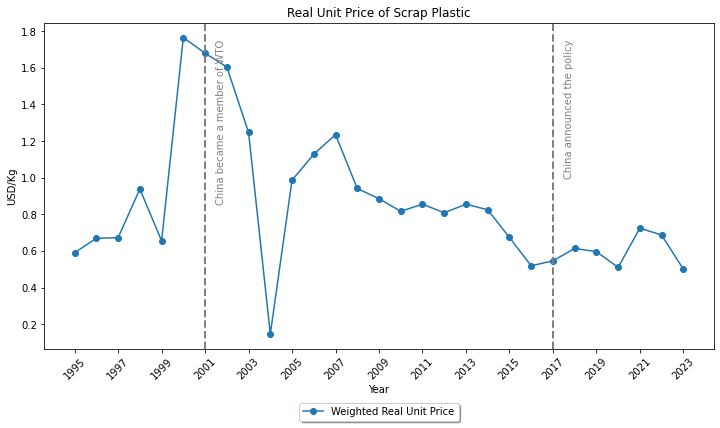

In [71]:
import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plot data with markers
plt.plot(Average_Prices['Year'], Average_Prices['Weighted_Real_Unit_Price'], marker='o', label='Weighted Real Unit Price')

# Add vertical line for the year 2001
plt.axvline(x=2001, color='grey', linestyle='--', linewidth=2)
plt.text(2001.5, plt.ylim()[1]*0.95, 'China became a member of WTO', verticalalignment='top', horizontalalignment='left', color='grey', rotation=90)

# Add vertical line for the year 2017
plt.axvline(x=2017, color='grey', linestyle='--', linewidth=2)
plt.text(2017.5, plt.ylim()[1]*0.95, 'China announced the policy', verticalalignment='top', horizontalalignment='left', color='grey', rotation=90)

# Label axes and title
plt.xlabel("Year")
plt.ylabel("USD/Kg")
plt.title("Real Unit Price of Scrap Plastic")

# Customize x-ticks to prevent overlapping (Assuming 'Year' is in a format that needs adjusting)
plt.xticks(Average_Prices['Year'][::2], rotation=45)  # Adjust according to the actual data for a clean look

# Legend positioning below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=1)

# Save the figure with high resolution
plt.savefig('real_unit_price_scrap_plastic.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [72]:
# Importing Data

all_data = pd.read_csv("UN_COMTRADE_SCRAP_PAPER.csv")

data = all_data[["Period", "ReporterISO", "ReporterDesc", "MotCode", "MotDesc","QtyUnitAbbr", "NetWgt","IsNetWgtEstimated", "Fobvalue"]]
data.columns = ["Year", "Importer_Code", "Importer_Country","MOT_Code", "MOT_Desc", "Unit", "Weight", "IsWeightEstimated", "FOB_Value"]

data.head()

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value
0,1995,BEL,Belgium-Luxembourg (...1998),0,TOTAL MOT,kg,766312.0,False,157107.0
1,1995,BRA,Brazil,0,TOTAL MOT,kg,6062.0,False,887.0
2,1995,CAN,Canada,0,TOTAL MOT,kg,429118000.0,False,83932312.0
3,1995,CHN,China,0,TOTAL MOT,kg,3172875.0,False,264844.0
4,1995,SLV,El Salvador,0,TOTAL MOT,kg,36144.0,False,4736.0


In [73]:
# Only use Total MOT for not to double count
df = data[data["MOT_Code"] == 0]

# Get rid of NAN or 0 entries for weight
df = df[~df['Weight'].isin([np.NaN, 0.0])]

In [74]:
# Calculating Unit Price
df['Unit_Price'] = df['FOB_Value'] / df['Weight']

# Merging CPI with df to calculate real prices
df = pd.merge(left=df, right=cpi, on= "Year")

df["Real_Unit_Price"] = df['Unit_Price'] / df['CPI']

df.tail(5)

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value,Unit_Price,CPI,Real_Unit_Price
998,2023,SWE,Sweden,0,TOTAL MOT,kg,182543.499,True,23750.816,0.130110,1.0,0.130110
999,2023,CHE,Switzerland,0,TOTAL MOT,kg,400.926,True,1069.173,2.666759,1.0,2.666759
1000,2023,TUR,Türkiye,0,TOTAL MOT,kg,3922.000,False,629.000,0.160377,1.0,0.160377
1001,2023,GBR,United Kingdom,0,TOTAL MOT,kg,256794.487,True,80325.512,0.312801,1.0,0.312801
1002,2023,URY,Uruguay,0,TOTAL MOT,kg,100000.000,False,31062.000,0.310620,1.0,0.310620


In [75]:
# Calculate total weight per year
df['Total_Weight_Per_Year'] = df.groupby('Year')['Weight'].transform('sum')

# Calculate the weight ratio
df['Weight_Ratio'] = df['Weight'] / df['Total_Weight_Per_Year']

# Calculate the weighted price 
df["Weighted_Real_Unit_Price"] = df['Real_Unit_Price'] * df['Weight_Ratio']

# Calculating average price for each year
Average_Prices = df.groupby('Year', as_index=False)['Weighted_Real_Unit_Price'].sum()


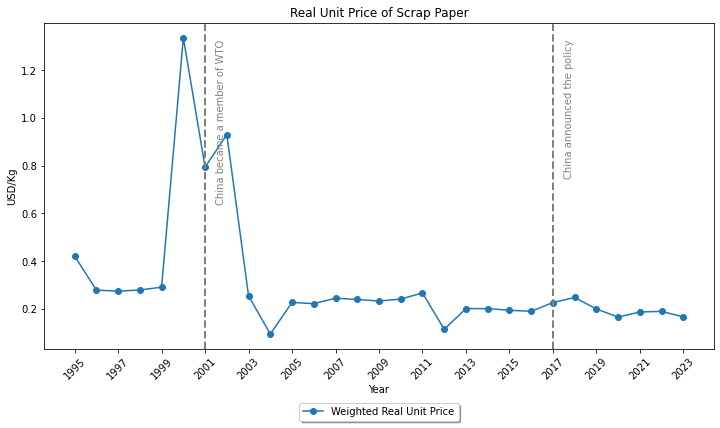

In [76]:
import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plot data with markers
plt.plot(Average_Prices['Year'], Average_Prices['Weighted_Real_Unit_Price'], marker='o', label='Weighted Real Unit Price')

# Add vertical line for the year 2001
plt.axvline(x=2001, color='grey', linestyle='--', linewidth=2)
plt.text(2001.5, plt.ylim()[1]*0.95, 'China became a member of WTO', verticalalignment='top', horizontalalignment='left', color='grey', rotation=90)

# Add vertical line for the year 2017
plt.axvline(x=2017, color='grey', linestyle='--', linewidth=2)
plt.text(2017.5, plt.ylim()[1]*0.95, 'China announced the policy', verticalalignment='top', horizontalalignment='left', color='grey', rotation=90)

# Label axes and title
plt.xlabel("Year")
plt.ylabel("USD/Kg")
plt.title("Real Unit Price of Scrap Paper")

# Customize x-ticks to prevent overlapping (Assuming 'Year' is in a format that needs adjusting)
plt.xticks(Average_Prices['Year'][::2], rotation=45)  # Adjust according to the actual data for a clean look

# Legend positioning below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=1)

# Save the figure with high resolution
plt.savefig('real_unit_price_scrap_plastic.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [81]:
# Importing Data

all_data = pd.read_csv("UN_COMTRADE_SCRAP_Metal.csv")

data = all_data[["Period", "ReporterISO", "ReporterDesc", "MotCode", "MotDesc","QtyUnitAbbr", "NetWgt","IsNetWgtEstimated", "Fobvalue"]]
data.columns = ["Year", "Importer_Code", "Importer_Country","MOT_Code", "MOT_Desc", "Unit", "Weight", "IsWeightEstimated", "FOB_Value"]

data.head()

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value
0,1995,ARG,Argentina,0,TOTAL MOT,kg,87824.0,False,152751.0
1,1995,AUS,Australia,0,TOTAL MOT,NaN,NaN,False,12340.0
2,1995,BEL,Belgium-Luxembourg (...1998),0,TOTAL MOT,kg,12562.0,False,9690.0
3,1995,BRA,Brazil,0,TOTAL MOT,kg,54101.0,False,24149.0
4,1995,BLZ,Belize,0,TOTAL MOT,kg,34980.0,False,3278.0


In [82]:
# Only use Total MOT for not to double count
df = data[data["MOT_Code"] == 0]

# Get rid of NAN or 0 entries for weight
df = df[~df['Weight'].isin([np.NaN, 0.0])]

In [83]:
# Calculating Unit Price
df['Unit_Price'] = df['FOB_Value'] / df['Weight']

# Merging CPI with df to calculate real prices
df = pd.merge(left=df, right=cpi, on= "Year")

df["Real_Unit_Price"] = df['Unit_Price'] / df['CPI']

df.head(5)

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value,Unit_Price,CPI,Real_Unit_Price
0,1995,ARG,Argentina,0,TOTAL MOT,kg,8.782400e+04,False,152751.0,1.739285,0.500136,3.477622
1,1995,BEL,Belgium-Luxembourg (...1998),0,TOTAL MOT,kg,1.256200e+04,False,9690.0,0.771374,0.500136,1.542327
2,1995,BRA,Brazil,0,TOTAL MOT,kg,5.410100e+04,False,24149.0,0.446369,0.500136,0.892494
3,1995,BLZ,Belize,0,TOTAL MOT,kg,3.498000e+04,False,3278.0,0.093711,0.500136,0.187370
4,1995,CAN,Canada,0,TOTAL MOT,kg,1.619611e+09,False,225830502.0,0.139435,0.500136,0.278794


In [84]:
# Calculate total weight per year
df['Total_Weight_Per_Year'] = df.groupby('Year')['Weight'].transform('sum')

# Calculate the weight ratio
df['Weight_Ratio'] = df['Weight'] / df['Total_Weight_Per_Year']

# Calculate the weighted price 
df["Weighted_Real_Unit_Price"] = df['Real_Unit_Price'] * df['Weight_Ratio']

# Calculating average price for each year
Average_Prices = df.groupby('Year', as_index=False)['Weighted_Real_Unit_Price'].sum()


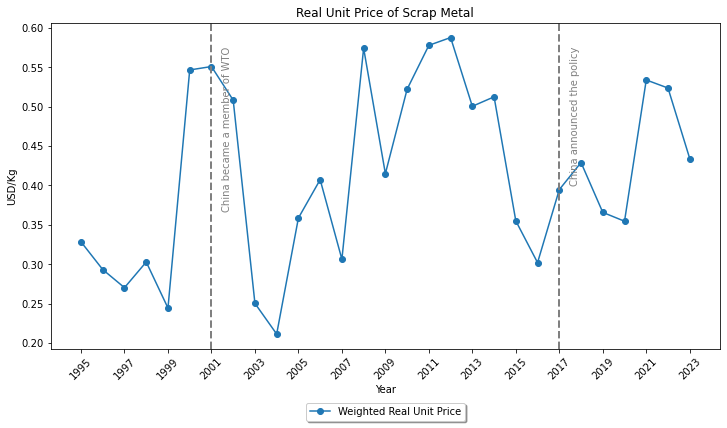

In [85]:
import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plot data with markers
plt.plot(Average_Prices['Year'], Average_Prices['Weighted_Real_Unit_Price'], marker='o', label='Weighted Real Unit Price')

# Add vertical line for the year 2001
plt.axvline(x=2001, color='grey', linestyle='--', linewidth=2)
plt.text(2001.5, plt.ylim()[1]*0.95, 'China became a member of WTO', verticalalignment='top', horizontalalignment='left', color='grey', rotation=90)

# Add vertical line for the year 2017
plt.axvline(x=2017, color='grey', linestyle='--', linewidth=2)
plt.text(2017.5, plt.ylim()[1]*0.95, 'China announced the policy', verticalalignment='top', horizontalalignment='left', color='grey', rotation=90)

# Label axes and title
plt.xlabel("Year")
plt.ylabel("USD/Kg")
plt.title("Real Unit Price of Scrap Metal")

# Customize x-ticks to prevent overlapping (Assuming 'Year' is in a format that needs adjusting)
plt.xticks(Average_Prices['Year'][::2], rotation=45)  # Adjust according to the actual data for a clean look

# Legend positioning below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=1)

# Save the figure with high resolution
plt.savefig('real_unit_price_scrap_plastic.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()